Using cache found in /Users/nabakgood/.cache/torch/hub/huggingface_pytorch-transformers_main


Epoch 1: Train Loss: 260.7004
Train Accuracy: 0.652 | Test Accuracy: 0.649
Epoch 2: Train Loss: 231.4174
Train Accuracy: 0.708 | Test Accuracy: 0.701
Epoch 3: Train Loss: 212.9495
Train Accuracy: 0.748 | Test Accuracy: 0.738
Epoch 4: Train Loss: 193.9184
Train Accuracy: 0.779 | Test Accuracy: 0.758
Epoch 5: Train Loss: 177.9203
Train Accuracy: 0.805 | Test Accuracy: 0.778
Epoch 6: Train Loss: 166.0761
Train Accuracy: 0.821 | Test Accuracy: 0.786
Epoch 7: Train Loss: 157.3936
Train Accuracy: 0.832 | Test Accuracy: 0.791
Epoch 8: Train Loss: 150.3755
Train Accuracy: 0.843 | Test Accuracy: 0.795
Epoch 9: Train Loss: 143.2687
Train Accuracy: 0.852 | Test Accuracy: 0.798
Epoch 10: Train Loss: 138.0302
Train Accuracy: 0.861 | Test Accuracy: 0.803


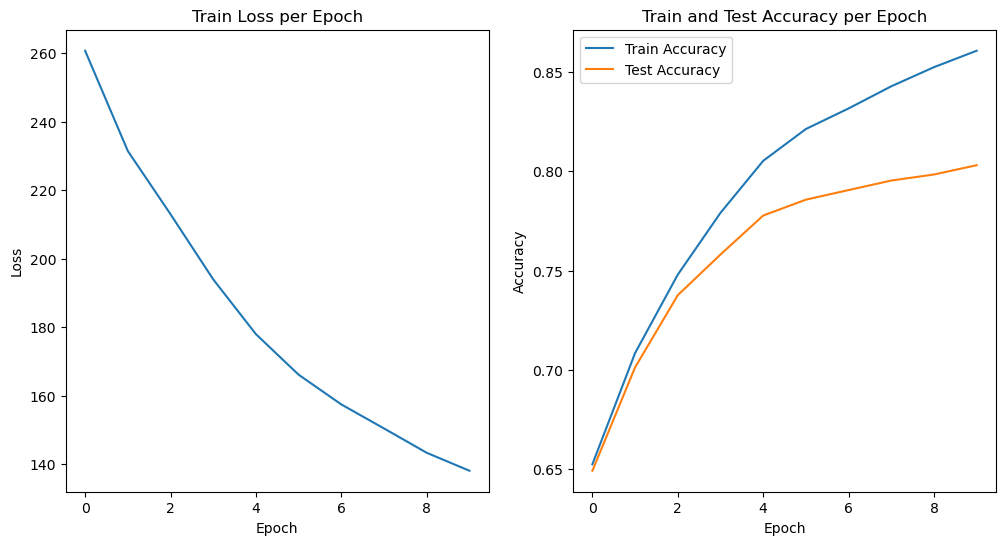

In [69]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam
from math import sqrt
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from torch.nn.utils.rnn import pad_sequence
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

# 데이터셋 로딩
ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')

# 새로운 collate_fn 정의
def collate_fn(batch):
    max_len = 400
    texts, labels = [], []
    for row in batch:
        labels.append(row['label'])  # 레이블은 이미 0 또는 1로 되어 있음
        texts.append(torch.LongTensor(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[:-2]))

    texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
    labels = torch.LongTensor(labels)

    return texts, labels

# DataLoader 정의
train_loader = DataLoader(ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn)

# Multi-Head Attention (MHA) 구현
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, d_model, n_heads):
        super().__init__()

        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = d_model // n_heads

        # Linear layers for Q, K, V
        self.wq = nn.Linear(input_dim, d_model)
        self.wk = nn.Linear(input_dim, d_model)
        self.wv = nn.Linear(input_dim, d_model)

        self.fc_out = nn.Linear(d_model, d_model)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask):
        batch_size = x.shape[0]
        seq_len = x.shape[1]

        # Linear projections for Q, K, V
        Q = self.wq(x)  # (B, S, D)
        K = self.wk(x)  # (B, S, D)
        V = self.wv(x)  # (B, S, D)

        # Reshape for multi-head attention
        Q = Q.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)  # (B, H, S, D')
        K = K.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)  # (B, H, S, D')
        V = V.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)  # (B, H, S, D')

        # Attention score calculation
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)  # (B, H, S, S)
        if mask is not None:
            scores = scores + (mask.unsqueeze(1) * -1e9)  # Apply mask

        attn = self.softmax(scores)  # (B, H, S, S)
        output = torch.matmul(attn, V)  # (B, H, S, D')

        # Concatenate heads and pass through output linear layer
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.n_heads * self.d_k)
        output = self.fc_out(output)  # (B, S, D)

        return output

# Transformer Layer 수정
class TransformerLayer(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.input_dim = input_dim
        self.d_model = d_model
        self.dff = dff

        self.mha = MultiHeadAttention(input_dim, d_model, n_heads)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Linear(dff, d_model)
        )

        self.dropout = nn.Dropout(dropout_rate)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)

    def forward(self, x, mask):
        # Multi-head attention
        attn_output = self.mha(x, mask)
        attn_output = self.dropout(attn_output)
        x1 = self.layernorm1(attn_output + x)  # Residual connection

        # Feedforward network
        ffn_output = self.ffn(x1)
        ffn_output = self.dropout(ffn_output)
        x2 = self.layernorm2(ffn_output + x1)  # Residual connection

        return x2

# TextClassifier 수정
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, dff, max_len=400):
        super().__init__()

        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.dff = dff
        self.n_heads = n_heads

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
        self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, n_heads, dff) for _ in range(n_layers)])

        # 감정 분석을 위한 2개의 클래스 (positive, negative)
        self.classification = nn.Linear(d_model, 2)  # 2개의 클래스로 분류

    def forward(self, x):
        mask = (x == tokenizer.pad_token_id)
        mask = mask[:, None, :]
        seq_len = x.shape[1]

        x = self.embedding(x)
        x = x * sqrt(self.d_model)
        x = x + self.pos_encoding[:, :seq_len]

        for layer in self.layers:
            x = layer(x, mask)

        x = x[:, 0]  # 첫 번째 토큰만 사용 (BERT에서 [CLS] 토큰)
        x = self.classification(x)  # 감정 분석을 위한 출력

        return x

# 모델 초기화
device = torch.device('mps')

model = TextClassifier(len(tokenizer), 32, 2, 4, 32)
model = model.to(device)

# 손실 함수 및 옵티마이저 정의
loss_fn = nn.CrossEntropyLoss()  # CrossEntropyLoss 사용
optimizer = Adam(model.parameters(), lr=0.0001)  # 학습률 조정

# 정확도 계산 함수
def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # 모델 예측
        preds = model(inputs)  # 모델의 예측값 (batch_size, 2)

        # 예측값에서 가장 높은 확률의 클래스 인덱스 추출
        _, predicted = torch.max(preds, dim=-1)  # (batch_size,)

        # 정확도 계산
        cnt += labels.shape[0]
        acc += (predicted == labels).sum().item()

    return acc / cnt

# 학습
n_epochs = 10
train_losses, train_accs, test_accs = [], [], []

for epoch in range(n_epochs):
    total_loss = 0.
    model.train()
    # 학습 루프 내에서 손실 계산 부분 수정
    for data in train_loader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # 모델 예측
        preds = model(inputs)  # 모델의 예측값

        # CrossEntropyLoss는 logits을 입력으로 받으므로 reshape하지 않음
        loss = loss_fn(preds, labels)  # preds: (batch_size, 2), labels: (batch_size,)

        # 역전파 및 최적화
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Train Loss: {total_loss:.4f}")
    
    # 평가
    with torch.no_grad():
        model.eval()
        train_acc = accuracy(model, train_loader)
        test_acc = accuracy(model, test_loader)
        print(f"Train Accuracy: {train_acc:.3f} | Test Accuracy: {test_acc:.3f}")

    train_losses.append(total_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)


# 학습 결과 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(n_epochs), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss per Epoch')

plt.subplot(1, 2, 2)
plt.plot(range(n_epochs), train_accs, label='Train Accuracy')
plt.plot(range(n_epochs), test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Test Accuracy per Epoch')

plt.show()
